In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from pathlib import Path
import warnings
import os
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

import shap

In [3]:
# plt.rcParams['font.family'] = "MS Gothic"
warnings.simplefilter('ignore')

In [4]:
def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
fix_all_seeds(0)

In [5]:
# Config
SAVE_SUB = False
SAVE_SUB_DIR = Path("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/sub_20230225")
SUB_FILE_NAME = "val5"

# データ読み込み

In [6]:
train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/train.pkl")
test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/test.pkl")
sub = pd.read_csv("/content/drive/MyDrive/Kaggle/BlueCarbon/raw/submit_example.csv")

# 特徴抽出後のデータ
umap_basic_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_train.pkl")
umap_basic_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_test.pkl")
umap_marine_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_marine_train.pkl")
umap_marine_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_marine_test.pkl")
umap_basic_marine_train = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_marine_train.pkl")
umap_basic_marine_test = pd.read_pickle("/content/drive/MyDrive/Kaggle/BlueCarbon/proc/FE_20230417/20230417_umap_basic_marine_test.pkl")

train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13


In [7]:
sub.head(2)

,0,0.47
0,1,0.68
1,2,0.25


# 前処理

## 対数変換

In [8]:
train[f"log_cover"] = np.log1p(train["cover"])

## UMAPのデータを結合

### 基本情報

In [9]:
print(train.shape)
print(umap_basic_train.shape)
print(test.shape)
print(umap_basic_test.shape)
umap_basic_train.head(2)

(14140, 3465)
(14140, 3)
(4039, 3463)
(4039, 3)


,dim0,dim1,temp_monthly
0,1.788618,6.597842,27.9
1,-10.111396,6.170877,29.2


In [10]:
train = train.join(umap_basic_train)
test = test.join(umap_basic_test)
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,log_cover,dim0,dim1,temp_monthly
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10,0.048790,1.788618,6.597842,27.9
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13,0.545227,-10.111396,6.170877,29.2


### 海洋

In [11]:
print(train.shape)
print(umap_marine_train.shape)
print(test.shape)
print(umap_marine_test.shape)
umap_marine_train.head(2)

(14140, 3468)
(14140, 2)
(4039, 3466)
(4039, 2)


,dim0,dim1
0,-5.700604,5.185160
1,2.617091,7.921879


In [12]:
umap_marine_train.columns = ["dim0_marine", "dim1_marine"]
umap_marine_test.columns = ["dim0_marine", "dim1_marine"]

train = train.join(umap_marine_train)
test = test.join(umap_marine_test)
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,log_cover,dim0,dim1,temp_monthly,dim0_marine,dim1_marine
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,95.142525,3.728732,-2.405135,3725_10,0.048790,1.788618,6.597842,27.9,-5.700604,5.185160
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,174.767501,-0.571513,0.448861,4027_13,0.545227,-10.111396,6.170877,29.2,2.617091,7.921879


### 基本+海洋

In [13]:
print(train.shape)
print(umap_basic_marine_train.shape)
print(test.shape)
print(umap_basic_marine_test.shape)
umap_basic_marine_train.head(2)

(14140, 3470)
(14140, 2)
(4039, 3468)
(4039, 2)


,dim0,dim1
0,12.295664,7.637266
1,-1.609052,17.003418


In [14]:
umap_basic_marine_train.columns = ["dim0_basic_marine", "dim1_basic_marine"]
umap_basic_marine_test.columns = ["dim0_basic_marine", "dim1_basic_marine"]

train = train.join(umap_basic_marine_train)
test = test.join(umap_basic_marine_test)
train.head(2)

,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,aicial_length,...,MIN_VARIgreen_2020,mesh20,log_cover,dim0,dim1,temp_monthly,dim0_marine,dim1_marine,dim0_basic_marine,dim1_basic_marine
0,24.989140,125.243164,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,0.000000,...,-2.405135,3725_10,0.048790,1.788618,6.597842,27.9,-5.700604,5.185160,12.295664,7.637266
1,26.996172,127.912025,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,0.478772,...,0.448861,4027_13,0.545227,-10.111396,6.170877,29.2,2.617091,7.921879,-1.609052,17.003418


## 使用する特徴量

In [15]:
# 被度文献データ、海洋環境要因データ、landsat使用
# YMDは使わない
cols_base = train.columns.to_list()[:25]
cols_umap_basic = [
    "dim0",
    "dim1", 
    "temp_monthly", 
    "dim0_marine", 
    "dim1_marine", 
    "dim0_basic_marine", 
    "dim1_basic_marine"
]
# cols_sentinel = train.columns.to_list()[88:313]
# cols_sentinel = [col for col in cols_sentinel if "MED" in col]
cols_use = cols_base + cols_umap_basic + ["log_cover"] # + cols_sentinel

cols_remove = ["YMD", "month"]
cols_use = [col for col in cols_use if not col in cols_remove]
cols_use

['lat',
 'lon',
 'area',
 'year',
 'cover',
 'depth_original',
 'cliff_length',
 'aicial_length',
 'beach_length',
 'coast_length',
 'coastal_dist',
 'cold_sst',
 'depth',
 'fetch',
 'hist_cold_sst',
 'hist_warm_sst',
 'river_area',
 'river_dist',
 'Salinity_annual',
 'warm_sst',
 'sst_annual',
 'sst_ymd',
 'sst_diff',
 'dim0',
 'dim1',
 'temp_monthly',
 'dim0_marine',
 'dim1_marine',
 'dim0_basic_marine',
 'dim1_basic_marine',
 'log_cover']

In [16]:
train = train[cols_use]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14140 entries, 0 to 14139
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lat                14140 non-null  float32
 1   lon                14140 non-null  float32
 2   area               14140 non-null  float32
 3   year               14140 non-null  float32
 4   cover              14140 non-null  float32
 5   depth_original     4419 non-null   float32
 6   cliff_length       13849 non-null  float32
 7   aicial_length      13849 non-null  float32
 8   beach_length       13849 non-null  float32
 9   coast_length       13849 non-null  float32
 10  coastal_dist       13849 non-null  float32
 11  cold_sst           13849 non-null  float32
 12  depth              13849 non-null  float32
 13  fetch              13849 non-null  float32
 14  hist_cold_sst      13849 non-null  float32
 15  hist_warm_sst      13849 non-null  float32
 16  river_area         138

In [17]:
cols_obj = ["cover", "log_cover"]
features = [col for col in cols_use if col not in cols_obj]
print("特徴量の数：", len(features))

特徴量の数： 29


# CV

shap:  

https://data-analysis-stats.jp/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92/%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%A2%E3%83%87%E3%83%AB%E3%82%92%E8%A7%A3%E9%87%88%E3%81%99%E3%82%8Bshap/

In [18]:
# train_date = train[["year", "month"]].copy()

# def convert_int_into_str(x):
#     x_str = str(int(x))
#     if len(x_str)==1:
#         return "0" + x_str
#     return x_str

# train_date["month_str"] = train_date["month"].apply(convert_int_into_str)
# train_date["year_month"] = (train_date["year"].astype(int).astype(str) + train_date["month_str"]).astype(int)
# train_date.head()

In [19]:
# year_month = train_date["year_month"]
# cv = []

# val_idx1 = (year_month >= 200901)&(year_month <200907)
# train_idx1 = ~val_idx1
# cv.append([train_idx1, val_idx1])

# val_idx2 = (year_month >= 200910)&(year_month <200912)
# train_idx2 = ~val_idx2
# cv.append([train_idx2, val_idx2])

# val_idx3 = (year_month >= 201006)&(year_month <201009)
# train_idx3 = ~val_idx3
# cv.append([train_idx3, val_idx3])

# val_idx4 = (year_month >= 201010)&(year_month <201101)
# train_idx4 = ~val_idx4
# cv.append([train_idx4, val_idx4])

# val_idx5 = (year_month >= 201909)&(year_month <201910)
# train_idx5 = ~val_idx5
# cv.append([train_idx5, val_idx5])

In [20]:
def my_cross_val_predict(df, df_test, y_name=None, y_raw_name=None, params=None, features=None, cv=None, split=5, eval_by_shap=True):
    # CVの結果を集約する変数
    results_rmse = []
    dict_learning_rate = {}
    fi_df = pd.DataFrame()
    fi_df['features'] = features

    # kfoldで5分割
    kfold = KFold(n_splits=split, shuffle=True, random_state=42)
    X = df[features].values
    y = df[y_name].values
    y_raw = df[y_raw_name].values

    # 同時にtestデータも予測する
    X_test = df_test[features].values
    y_pred_test_mean = np.zeros(len(X_test))

    for i, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print("###"*10)
        print(f"● CV{i}")
        print("###"*10)
        X_train = X[train_idx, :]
        y_train = y[train_idx]
        X_val = X[val_idx, :]
        y_val = y[val_idx]
        y_val_raw = y_raw[val_idx]

        train_dataset = lgb.Dataset(X_train,
                                    y_train,
                                    feature_name=features,)
        val_dataset = lgb.Dataset(X_val,
                                  y_val,
                                  feature_name=features,)
        
        evals_result = {}
        callbacks = [
            # lgb.log_evaluation(100),
            # lgb.early_stopping(200),
            lgb.record_evaluation(evals_result)
        ]

        # モデル作成
        model = lgb.train(params=params,
                          train_set=train_dataset,
                          valid_sets=[val_dataset],
                          callbacks=callbacks,
                          verbose_eval=500,)
        # valデータ予測
        y_pred_raw = model.predict(X_val)
        y_pred = np.expm1(y_pred_raw)
        y_pred[y_pred<0] = 0
        y_pred[y_pred>1] = 1
        print(np.average(y_pred))
        # testデータ予測
        y_pred_test_raw = model.predict(X_test)
        y_pred_test = np.expm1(y_pred_test_raw)
        # この処理は最後にやる
        # y_pred_test[y_pred_test<0] = 0
        # y_pred_test[y_pred_test>1] = 1
        y_pred_test_mean += (y_pred_test / split)
        
        # RMSE計算
        rmse = np.sqrt(mean_squared_error(y_val_raw, y_pred))
        results_rmse.append(rmse)

        # 予測結果の可視化
        fig, ax = plt.subplots()
        ax.grid(alpha=0.2)
        ax.scatter(y_pred, y_val_raw, s=2)
        ax.set_xlabel("Pred")
        ax.set_ylabel("True")
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_title(f"val_{i}")
        plt.show()

        # 特徴量重要度の抽出
        fi_df[f"importance_cv{i}"] = model.feature_importance(importance_type='gain')
        dict_learning_rate[f"fold_{i}"] = np.array(evals_result['valid_0']['fair'])

        # shapで評価
        if eval_by_shap:
            df_X_val = pd.DataFrame(X_val, columns=features)
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X=df_X_val)
            shap.summary_plot(shap_values, df_X_val)
        
    # 学習曲線の可視化
    print("###"*10)
    print("学習曲線")
    print("###"*10)
    fig, ax = plt.subplots()
    ax.grid(alpha=0.2)
    for key, value in dict_learning_rate.items():
        x = list(range(len(value)))
        ax.plot(x, value, label=key)
    ax.legend(loc="upper left", bbox_to_anchor=(1, 0.5))
    # ax.set_ylim([-0.05, 0.2])
    plt.show()

    # testデータの予測結果整理
    y_pred_test_mean[y_pred_test_mean<0] = 0
    y_pred_test_mean[y_pred_test_mean>1] = 1

    return results_rmse, fi_df, y_pred_test_mean

In [21]:
def plot_results(results):
    x_list = [f"cv{i}" for i in range(5)]
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot()
    ax.bar(x=x_list, height=results, label="RMSE", zorder=10)
    ax.set_ylabel("RMSE")
    # ax.set_ylim([0, 0.007])
    ax.grid(zorder=-10)
    ax.legend()
    plt.show()

# from: https://blog.amedama.jp/entry/lightgbm-cv-feature-importance
def plot_importance(fi_df, figsize=(10, 10)):
#     raw_importances = cvbooster.feature_importance(importance_type='gain')
    feature_name = fi_df.features.to_list()
    importance_df = pd.DataFrame(data=fi_df.iloc[:, 1:].values.T,
                             columns=feature_name)
    # 平均値でソートする
    sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    print(sorted_importance_df.shape)
    # 上位をプロットする
#     PLOT_TOP_N = 40
    plot_cols = sorted_importance_df.columns[:50]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.show()

##############################
● CV0
##############################
[500]	valid_0's fair: 0.00459195
[1000]	valid_0's fair: 0.00411275
[1500]	valid_0's fair: 0.00389807
[2000]	valid_0's fair: 0.00376331
0.1752030370376638


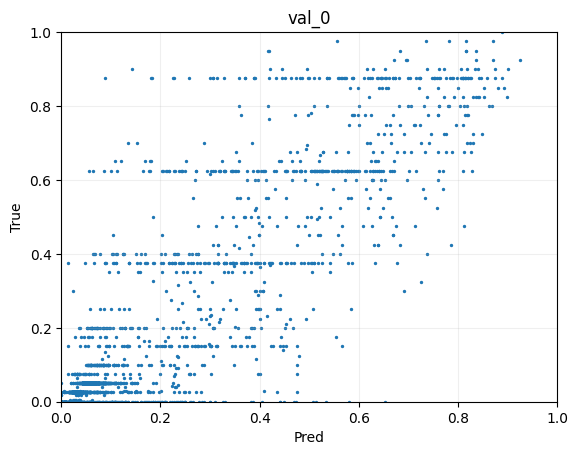

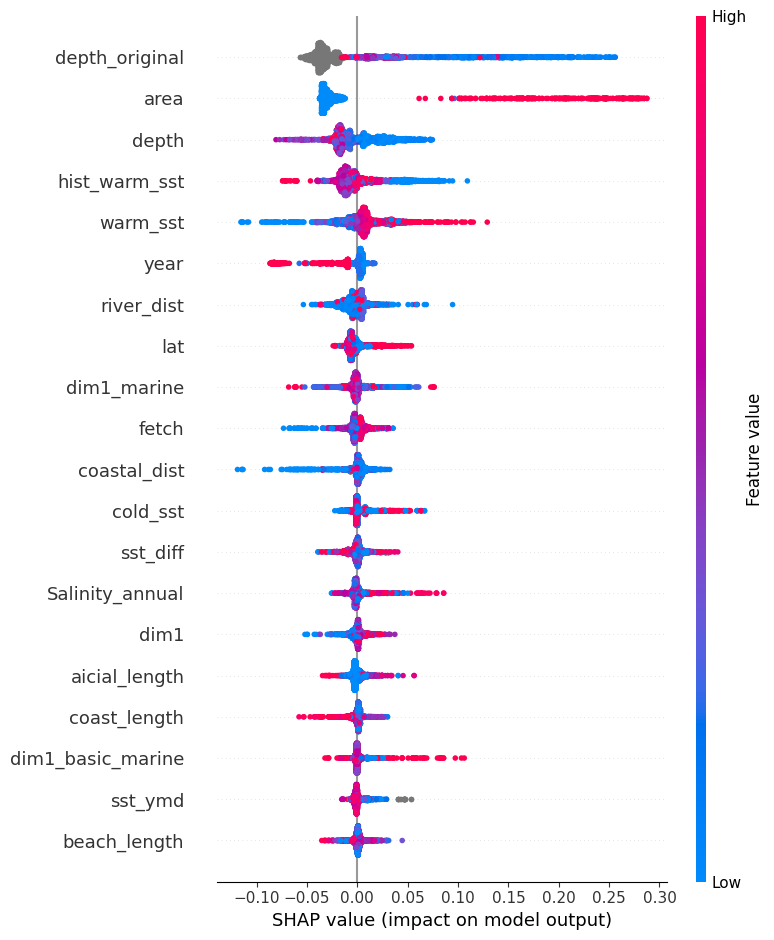

##############################
● CV1
##############################
[500]	valid_0's fair: 0.00468347
[1000]	valid_0's fair: 0.00420593
[1500]	valid_0's fair: 0.00395175
[2000]	valid_0's fair: 0.00379428
0.1755156190534868


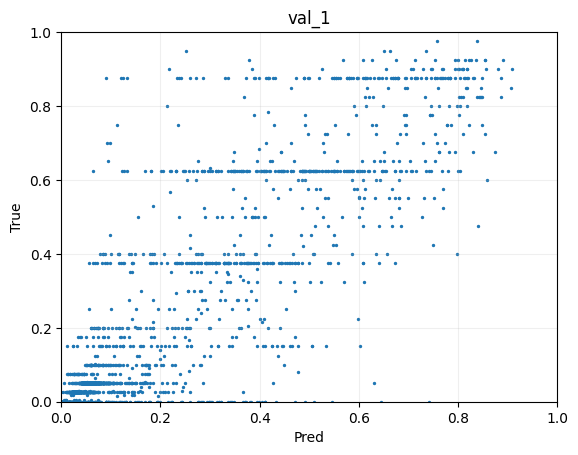

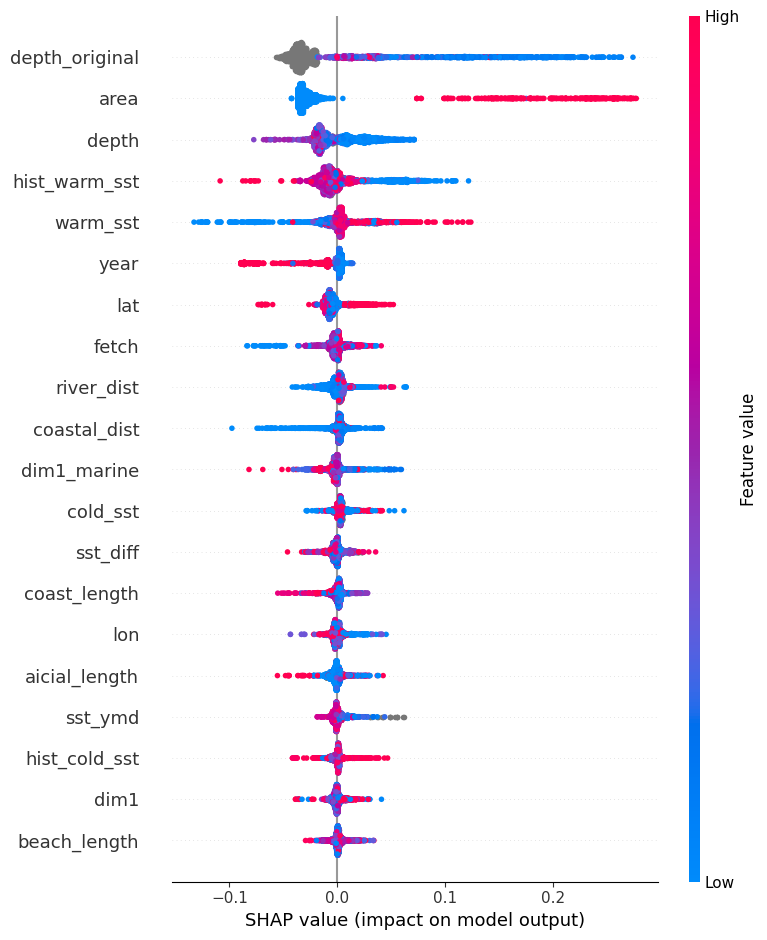

##############################
● CV2
##############################
[500]	valid_0's fair: 0.00475315
[1000]	valid_0's fair: 0.00425469
[1500]	valid_0's fair: 0.00398906
[2000]	valid_0's fair: 0.00383663
0.17855558247686107


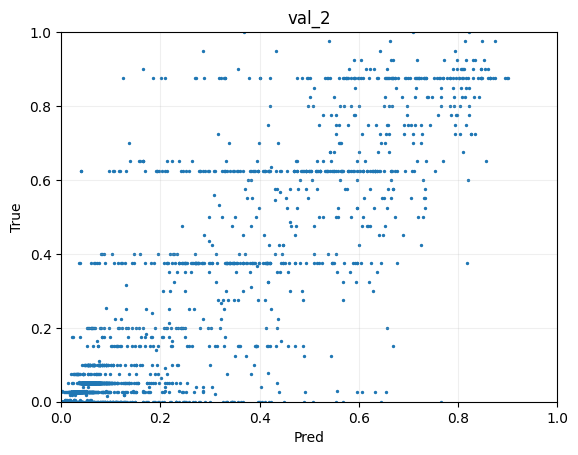

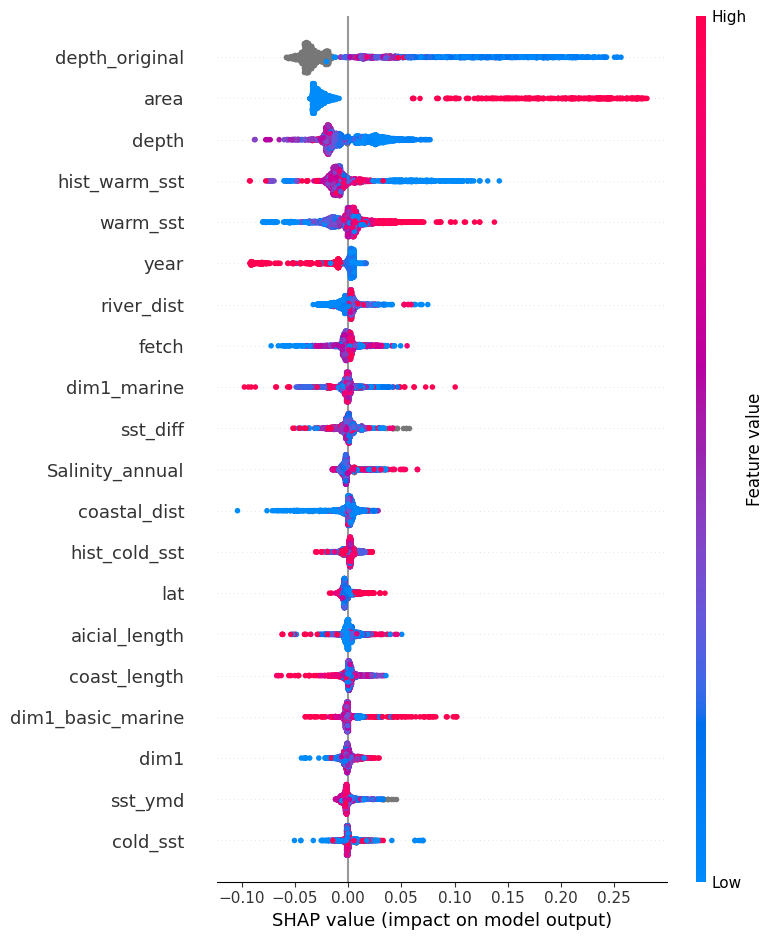

##############################
● CV3
##############################
[500]	valid_0's fair: 0.00436385
[1000]	valid_0's fair: 0.00390271
[1500]	valid_0's fair: 0.00362647
[2000]	valid_0's fair: 0.00343337
0.17478340284128444


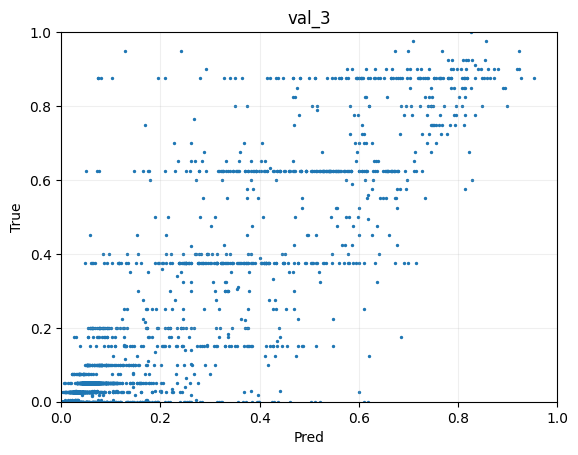

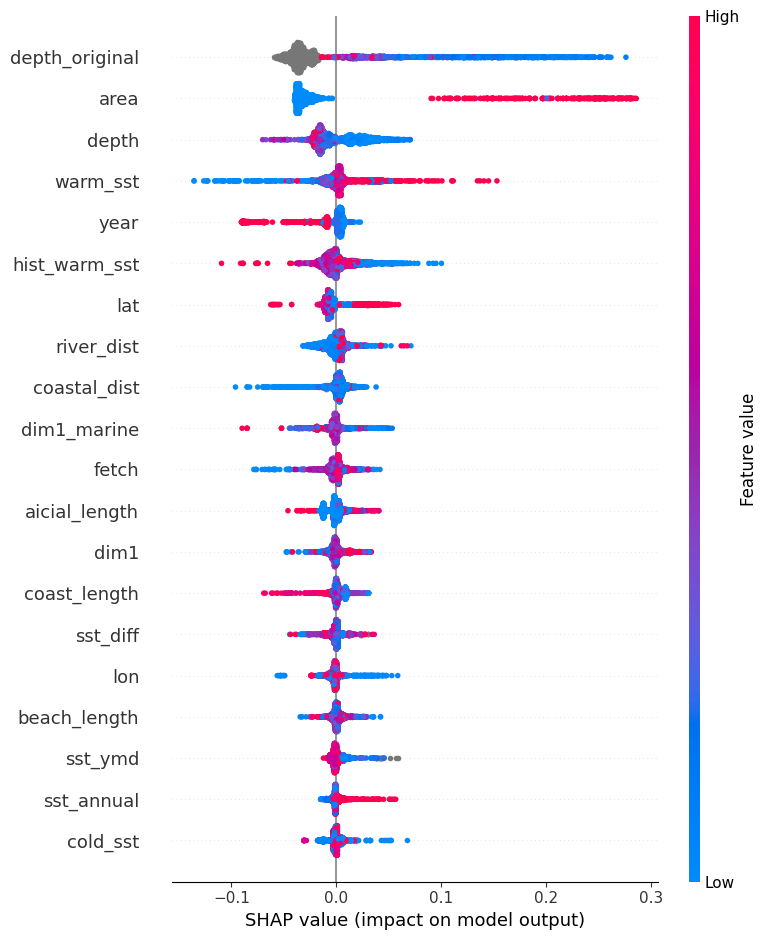

##############################
● CV4
##############################
[500]	valid_0's fair: 0.00509576
[1000]	valid_0's fair: 0.0045388
[1500]	valid_0's fair: 0.00427337
[2000]	valid_0's fair: 0.00408642
0.17386644304578822


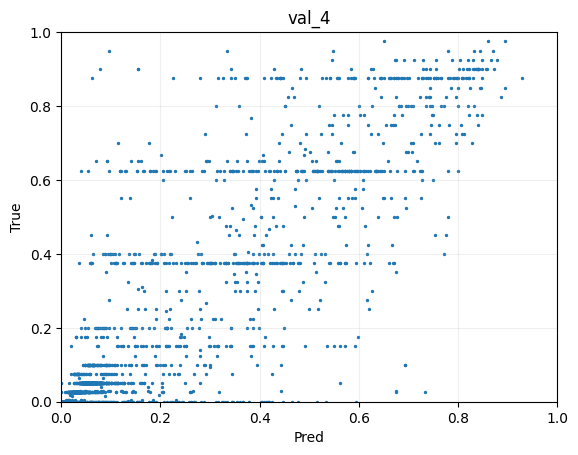

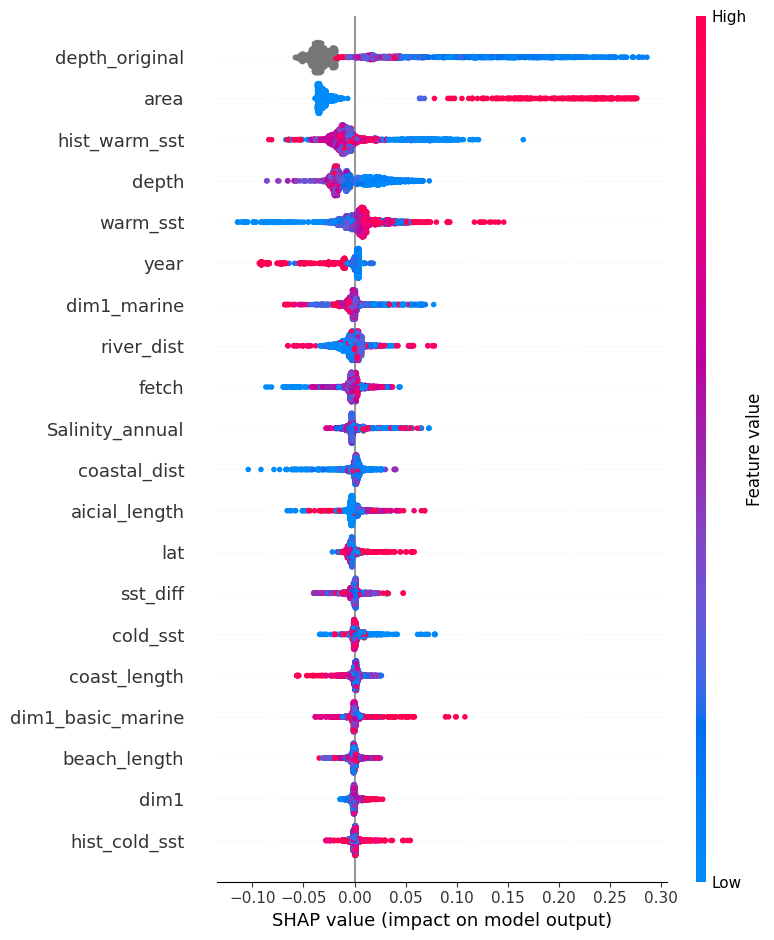

##############################
学習曲線
##############################


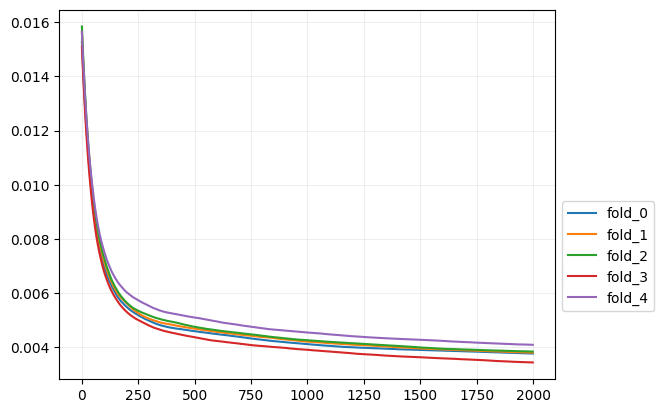

In [22]:
params = {
    'objective': 'fair',
    'metric': 'fair',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'n_estimators': 2000,
    'learning_rate': 0.01,
    # 'num_leaves': 50,
    # 'colsample_bytree': 0.6,
    # 'subsample': 0.5,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 46,
}

results_rmse, fi_df, y_test_pred = my_cross_val_predict(train, test, y_name="log_cover", y_raw_name="cover", params=params, features=features)

CV0: 0.128
CV1: 0.130
CV2: 0.130
CV3: 0.122
CV4: 0.134
Average: 0.129


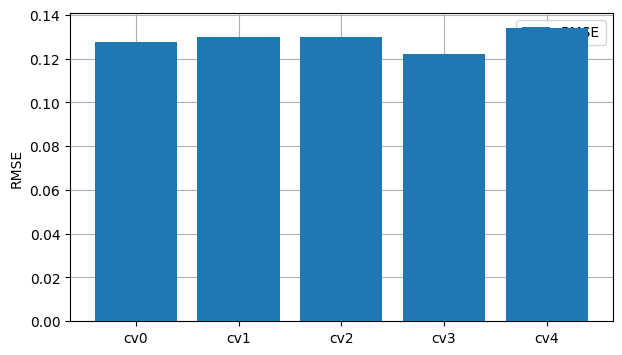

In [23]:
for i, rmse in enumerate(results_rmse):
    print(f"CV{i}: {rmse:.3f}")
print(f"Average: {np.average(results_rmse):.3f}")
plot_results(results_rmse)

(5, 29)


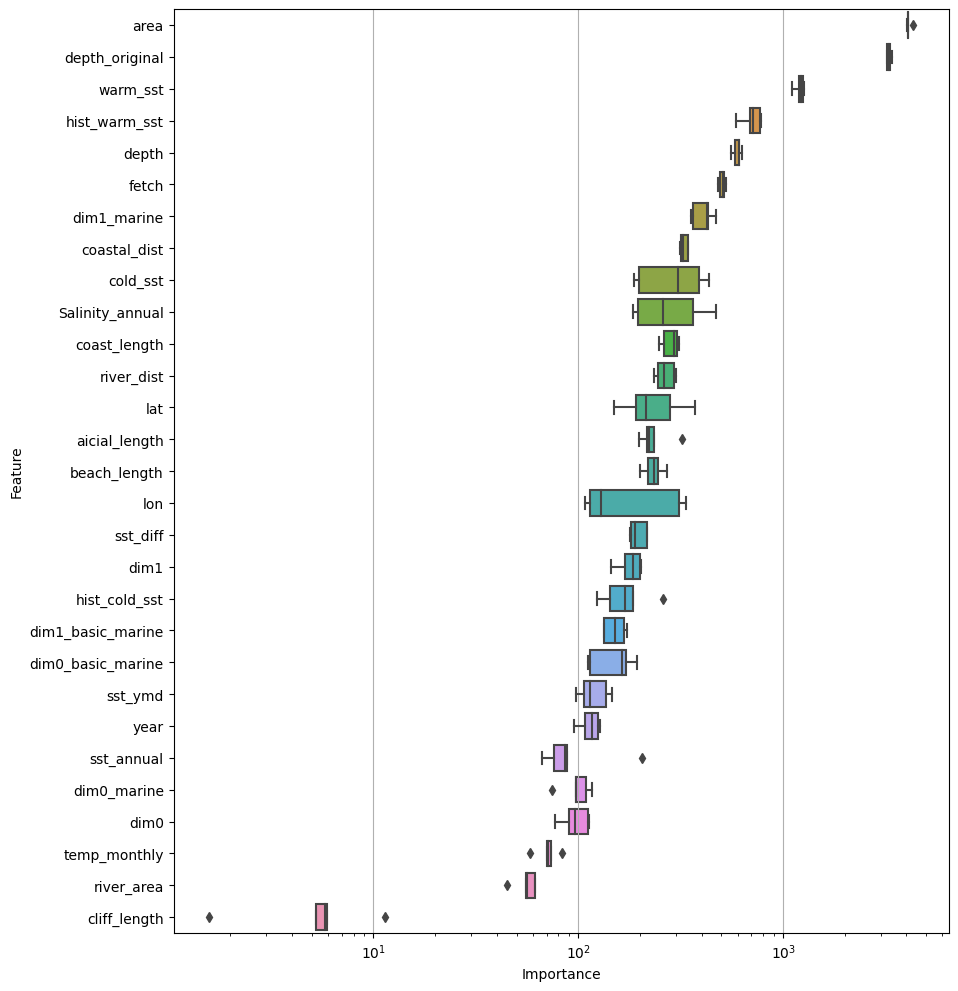

In [24]:
plot_importance(fi_df, figsize=(10, 12))

# Sub作成

In [25]:
test_sub = pd.DataFrame(y_test_pred, columns=["pred"])
test_sub

,pred
0,0.239829
1,0.083757
2,0.554183
3,0.051802
4,0.178975
...,...
4034,0.207372
4035,0.060582
4036,0.385925
4037,0.055671


In [26]:
test_pred_mean = test_sub["pred"].mean()
test_pred_mean

0.1942015083548379

In [27]:
test_sub2 = test_sub.copy()
public_mean = 0.09088
# test_sub["pred"] = test_sub["pred"] * (public_mean / test_pred_mean)
test_sub2["pred"] -= (test_pred_mean - public_mean)
test_sub2["pred"] = np.clip(test_sub2["pred"].values, 0, 1)
test_sub2

,pred
0,0.136508
1,0.000000
2,0.450861
3,0.000000
4,0.075653
...,...
4034,0.104051
4035,0.000000
4036,0.282604
4037,0.000000


In [28]:
print("pred_最小値:", test_sub["pred"].min())
print("pred_最大値:", test_sub["pred"].max())
print("pred_平均値:", test_sub["pred"].mean())

pred_最小値: 0.008820871688412297
pred_最大値: 0.834336408106946
pred_平均値: 0.1942015083548379


In [29]:
print("●後処理後")
print("pred_最小値:", test_sub2["pred"].min())
print("pred_最大値:", test_sub2["pred"].max())
print("pred_平均値:", test_sub2["pred"].mean())

●後処理後
pred_最小値: 0.0
pred_最大値: 0.7310148997521081
pred_平均値: 0.10999270003477468


In [30]:
if SAVE_SUB:
    test_sub.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}.csv", header=False)
    test_sub2.to_csv(SAVE_SUB_DIR / f"{SUB_FILE_NAME}_mod.csv", header=False)